<a href="https://colab.research.google.com/github/Minh-A/Dacon/blob/main/Dacon_ScikitLearn_Beta12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

from tqdm import tqdm  # 진행표시바

import xgboost as xgb  # XGBoost 불러오기
from xgboost import plot_importance  # Feature Importance를 불러오기 위함

from sklearn.ensemble import GradientBoostingRegressor  # 그레디언트 부스팅

In [2]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train.csv')
fn.tail()

,month,file_nm
477,2018-08,201808.npy
478,2018-09,201809.npy
479,2018-10,201810.npy
480,2018-11,201811.npy
481,2018-12,201812.npy


In [4]:
# 그냥
fn.iloc[255:,1]

255    200002.npy
256    200003.npy
257    200004.npy
258    200005.npy
259    200006.npy
          ...    
477    201808.npy
478    201809.npy
479    201810.npy
480    201811.npy
481    201812.npy
Name: file_nm, Length: 227, dtype: object

In [5]:
# 11개씩 - 200801 - 351:
# 12개씩 - 200701 - 339:
# 19개씩 - 200001 - 255:

dm = fn.iloc[255:,1]
dm.shape

(227,)

In [6]:
# 데이터 생성
data = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train/200001.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape

100%|██████████| 227/227 [01:55<00:00,  1.96it/s]


(228, 448, 304)

In [8]:
# 월별 데이터 셋 만들기

# 데이터 셋 형태 변환
data = data.reshape(228,1, 448,304)

# 월별로 데이터 셋 생성
for i in tqdm(range(12)):
  # globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i]), axis=0))

  # globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i], data[60+i], data[72+i], data[84+i], data[96+i], data[108+i], data[120+i], data[132+i]), axis=0))

  globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i], data[60+i], data[72+i], data[84+i], data[96+i], data[108+i], data[120+i],
                                                            data[132+i], data[144+i], data[156+i], data[168+i], data[180+i], data[192+i], data[204+i], data[216+i]), axis=0))

  print("\n",globals()['train{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열

100%|██████████| 12/12 [00:00<00:00, 282.68it/s]


 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)

 (19, 448, 304)


In [ ]:
# 월별 이동 데이터 셋 만들기

# 월별로 데이터 셋 생성
for i in tqdm(range(12)):
  a = globals()['train{}'.format(i)]
  globals()['mvtrain{}'.format(i)] = np.array(np.concatenate(((a[1] - a[0]).reshape(1, 448,304), (a[2] - a[1]).reshape(1, 448,304), (a[3] - a[2]).reshape(1, 448,304), (a[4] - a[3]).reshape(1, 448,304),
                                                               (a[5] - a[4]).reshape(1, 448,304), (a[6] - a[5]).reshape(1, 448,304), (a[7] - a[6]).reshape(1, 448,304), (a[8] - a[7]).reshape(1, 448,304),
                                                               (a[9] - a[8]).reshape(1, 448,304), (a[10] - a[9]).reshape(1, 448,304)), axis=0))

  print("\n",globals()['mvtrain{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열


# 함수 사용

In [9]:
def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 버리기
def fun(x) : 
  return np.trunc(x)

In [10]:
# 소숫점 둘째 자리 반올림
def fun1(x) : 
  return np.around(x,2)

In [11]:
# 점수 계산

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

# Scikit Learn 
> https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

> 머신러닝 앙상블 (ensemble) Gradient Boosting
* https://lsjsj92.tistory.com/544?category=853217
* https://wikidocs.net/26289

> 머신러닝 앙상블 (ensemble) RandomForest
* https://lsjsj92.tistory.com/542?category=853217

## 시험용

In [ ]:
# 데이터
x_train = train0[:9].reshape(9,-1).T
y_train = train0[9].reshape(1,-1).T
x_test = train0[1:10].reshape(9,-1).T

real = train0[10]

In [25]:
# 데이터 11개
x_train = train0[:10].reshape(10,-1).T
y_train = train0[10].reshape(1,-1).T
x_test = train0[1:11].reshape(10,-1).T

real = train0[11]

In [ ]:
# 데이터 형태 확인
x_test.shape

(136192, 10)

GradientBoost 모델

In [ ]:
# GradientBoost 모델 1
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(criterion='friedman_mse')
model.fit(x_train, y_train)

In [ ]:
# GradientBoost 모델 2
print(model.score(x_train, y_train))

In [ ]:
# GradientBoost 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# GradientBoost 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

RandomForest 모델

In [ ]:
# RandomForest 모델 1
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

In [ ]:
# RandomForest 모델 2
print(model.score(x_train, y_train))

In [ ]:
# RandomForest 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 4.57
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# RandomForest 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

Bayesian Regression 모델

In [ ]:
# Bayesian Regression 모델 1
from sklearn import linear_model

model = linear_model.BayesianRidge()
model.fit(x_train, y_train)

In [ ]:
# Bayesian Regression 모델 2
print(model.score(x_train, y_train))

In [ ]:
# Bayesian Regression 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# Bayesian Regression 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

SGDRegressor 모델

In [ ]:
# SGDRegressor 모델 1
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss='huber',learning_rate='optimal')
model.fit(x_train, y_train)

In [ ]:
# SGDRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# SGDRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# SGDRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

DecisionTreeRegressor 모델

In [ ]:
# DecisionTreeRegressor 모델 1
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(criterion='mse')
model.fit(x_train, y_train)

In [ ]:
# DecisionTreeRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# DecisionTreeRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 5.77
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# DecisionTreeRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

HuberRegressor 모델

In [ ]:
# HuberRegressor 모델 1
from sklearn.linear_model import HuberRegressor

model = HuberRegressor()
model.fit(x_train, y_train)

In [ ]:
# HuberRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# HuberRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# HuberRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

KNeighborsRegressor 모델

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=2000, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train, y_train))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test)
pre = pre.reshape(-1)
pre 

In [ ]:
pre = pre / 100
pre

In [ ]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# KNeighborsRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=780, weights='distance', p=1, n_jobs=-1)  # 1900에 3.59, 1500에 3.58
model.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=780, p=1,
                    weights='distance')

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train, y_train))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test)
pre = pre.reshape(-1)
pre 

In [ ]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# 항목 확인
# 배열 내 중복된 원소 제거 후 유일한 원소를 정렬하여 반환
np.unique(np.abs(fun(pre)))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

  0%|          | 0/14 [00:00<?, ?it/s]

1000


  7%|▋         | 1/14 [06:52<1:29:21, 412.41s/it]

MAE : 2.86378788768797 
 F1 : 0.8006562565211068 
 Final 3.5768006914268935
1100


 14%|█▍        | 2/14 [13:54<1:23:02, 415.17s/it]

MAE : 2.8538900963345863 
 F1 : 0.7958762695539336 
 Final 3.5858464055922257
1200


 21%|██▏       | 3/14 [21:10<1:17:16, 421.50s/it]

MAE : 2.844748590225564 
 F1 : 0.7925465647459214 
 Final 3.589377180940499
1300


 29%|██▊       | 4/14 [28:34<1:11:22, 428.27s/it]

MAE : 2.8365836466165413 
 F1 : 0.7897691636655108 
 Final 3.5916616414024705
1400


 36%|███▌      | 5/14 [36:13<1:05:37, 437.54s/it]

MAE : 2.830276374530075 
 F1 : 0.7882082183428847 
 Final 3.590772428854744
1500


 43%|████▎     | 6/14 [44:04<59:40, 447.52s/it]  

MAE : 2.8241746945488724 
 F1 : 0.7871671018023486 
 Final 3.587770185269122
1600


 50%|█████     | 7/14 [52:15<53:43, 460.51s/it]

MAE : 2.817353442199248 
 F1 : 0.7855340430409822 
 Final 3.586545269797824
1700


 57%|█████▋    | 8/14 [1:00:38<47:19, 473.25s/it]

MAE : 2.8134398496240602 
 F1 : 0.7815605644290718 
 Final 3.5997719711991247
1800


 64%|██████▍   | 9/14 [1:09:17<40:35, 487.04s/it]

MAE : 2.80910038768797 
 F1 : 0.7805084553649888 
 Final 3.599064599990407
1900


 71%|███████▏  | 10/14 [1:18:14<33:28, 502.20s/it]

MAE : 2.805164767387218 
 F1 : 0.7792869077822331 
 Final 3.599655920531062
2000


 79%|███████▊  | 11/14 [1:27:29<25:53, 517.83s/it]

MAE : 2.8024773848684212 
 F1 : 0.7775175451780625 
 Final 3.6043911371578155
2100


 86%|████████▌ | 12/14 [1:37:04<17:50, 535.08s/it]

MAE : 2.798850152725564 
 F1 : 0.776119383765195 
 Final 3.60621081654393
2200


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [100, 200, 300, 400, 500, 600]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))


  0%|          | 0/6 [00:00<?, ?it/s]

100



 17%|█▋        | 1/6 [06:06<30:31, 366.33s/it]

MAE : 2.717623208411654 
 F1 : 0.829461347803028 
 Final 3.276371084494821
200



 33%|███▎      | 2/6 [12:18<24:32, 368.01s/it]

MAE : 2.6255686090225563 
 F1 : 0.8281680255200053 
 Final 3.1703331889330477
300



 50%|█████     | 3/6 [18:34<18:31, 370.48s/it]

MAE : 2.5915519266917295 
 F1 : 0.8272287305462303 
 Final 3.132811760119085
400



 67%|██████▋   | 4/6 [24:58<12:28, 374.49s/it]

MAE : 2.5856482025375946 
 F1 : 0.8259812248453465 
 Final 3.130395817069284
500



 83%|████████▎ | 5/6 [31:34<06:20, 380.99s/it]

MAE : 2.5933186971334585 
 F1 : 0.8232622935851049 
 Final 3.1500515520268486
600



100%|██████████| 6/6 [38:16<00:00, 382.75s/it]

MAE : 2.606166661771616 
 F1 : 0.8198387475444642 
 Final 3.178877111857291


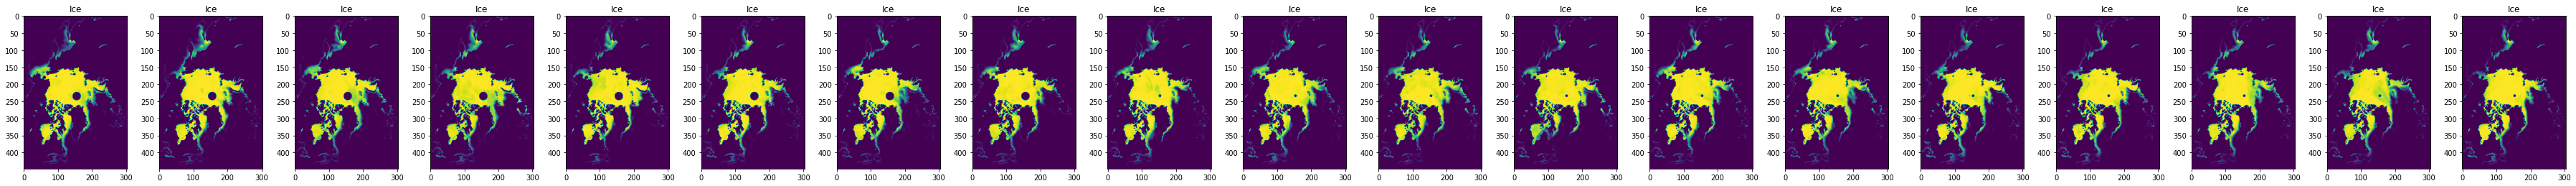

In [ ]:
# 전체 데이터 보기
show(train0)

In [ ]:
# 데이터 갯수 체크
x_train = train0[6:17].reshape( 11,-1).T
y_train = train0[17].reshape(1,-1).T  # 변동없음
x_test = train0[7:18].reshape( 11,-1).T
real = train0[18]  # 변동없음

In [ ]:
real[200,200]

245

In [ ]:
# real[200,200]

245

In [26]:
# 데이터 11개
x_train = train0[:10].reshape(10,-1).T
y_train = train0[10].reshape(1,-1).T
x_test = train0[1:11].reshape(10,-1).T

real = train0[11]

In [28]:
# 400내외에서 최적의 K를 찾자
from sklearn.neighbors import KNeighborsRegressor

# num = [340, 350, 360, 370, 380, 390, 400]
num = [410, 420, 430, 440, 450]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))



  0%|          | 0/5 [00:00<?, ?it/s]

410




 20%|██        | 1/5 [04:51<19:26, 291.52s/it]

MAE : 3.989420303688909 
 F1 : 0.8112665080921175 
 Final 4.917521202614107
420




 40%|████      | 2/5 [09:43<14:35, 291.80s/it]

MAE : 3.9863295200892863 
 F1 : 0.8112773121895068 
 Final 4.9136459396286645
430




 60%|██████    | 3/5 [14:37<09:44, 292.25s/it]

MAE : 3.978300707824247 
 F1 : 0.8112048936630624 
 Final 4.904187203331616
440




 80%|████████  | 4/5 [19:30<04:52, 292.67s/it]

MAE : 3.981153665413534 
 F1 : 0.8107588675971945 
 Final 4.910404036786226
450




100%|██████████| 5/5 [24:24<00:00, 292.88s/it]

MAE : 3.984956825657894 
 F1 : 0.8105404704541249 
 Final 4.9164192557356605


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/14 [00:00<?, ?it/s]

510


  7%|▋         | 1/14 [06:24<1:23:18, 384.47s/it]

MAE : 2.594504009046053 
 F1 : 0.8225017283630521 
 Final 3.154405502181248
520


 14%|█▍        | 2/14 [12:55<1:17:18, 386.52s/it]

MAE : 2.595175560972745 
 F1 : 0.8227693195583194 
 Final 3.1541957967318637
530


 21%|██▏       | 3/14 [19:27<1:11:07, 387.94s/it]

MAE : 2.5965816641212407 
 F1 : 0.8227074049128074 
 Final 3.156142289536108
540


 29%|██▊       | 4/14 [25:54<1:04:38, 387.84s/it]

MAE : 2.5976561765742483 
 F1 : 0.82237760370294 
 Final 3.1587146017724357
550


 36%|███▌      | 5/14 [32:23<58:12, 388.05s/it]  

MAE : 2.5990634545347744 
 F1 : 0.82237760370294 
 Final 3.1604258326438472
560


 43%|████▎     | 6/14 [38:55<51:55, 389.38s/it]

MAE : 2.6003092692669174 
 F1 : 0.8210599778415892 
 Final 3.1670149657428035
570


 50%|█████     | 7/14 [45:27<45:31, 390.15s/it]

MAE : 2.6018711084351502 
 F1 : 0.8212847704039772 
 Final 3.1680498293847967
580


 57%|█████▋    | 8/14 [52:00<39:06, 391.10s/it]

MAE : 2.60312228324718 
 F1 : 0.8212847704039772 
 Final 3.1695732653985678
590


 64%|██████▍   | 9/14 [58:35<32:41, 392.22s/it]

MAE : 2.6045882283834585 
 F1 : 0.8205217813692863 
 Final 3.1743071979074715
600


 71%|███████▏  | 10/14 [1:05:11<26:12, 393.22s/it]

MAE : 2.606166661771616 
 F1 : 0.8198387475444642 
 Final 3.178877111857291
610


 79%|███████▊  | 11/14 [1:11:50<19:45, 395.05s/it]

MAE : 2.6075837787828946 
 F1 : 0.8198387475444642 
 Final 3.1806056432279264
620


 86%|████████▌ | 12/14 [1:18:32<13:14, 397.04s/it]

MAE : 2.6090028782894734 
 F1 : 0.8200631170617998 
 Final 3.1814659045057385
630


 93%|█████████▎| 13/14 [1:25:11<06:37, 397.67s/it]

MAE : 2.6103014861372182 
 F1 : 0.8199368012491125 
 Final 3.183539817123979
640


100%|██████████| 14/14 [1:31:50<00:00, 393.63s/it]

MAE : 2.611831458529135 
 F1 : 0.8195224532244375 
 Final 3.1870163122226085


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/16 [00:00<?, ?it/s]

640


  6%|▋         | 1/16 [05:21<1:20:29, 321.95s/it]

MAE : 2.611831458529135 
 F1 : 0.8195224532244375 
 Final 3.1870163122226085
650


 12%|█▎        | 2/16 [10:44<1:15:08, 322.06s/it]

MAE : 2.6133668644266916 
 F1 : 0.8190442539759268 
 Final 3.190751683847337
660


 19%|█▉        | 3/16 [16:06<1:09:48, 322.18s/it]

MAE : 2.6148542498825185 
 F1 : 0.8187730521481996 
 Final 3.193625157894147
670


 25%|██▌       | 4/16 [21:29<1:04:28, 322.35s/it]

MAE : 2.6163273907424816 
 F1 : 0.8189973427737731 
 Final 3.194549264269935
680


 31%|███▏      | 5/16 [26:54<59:15, 323.23s/it]  

MAE : 2.6176212993421055 
 F1 : 0.8194932958526566 
 Final 3.194194852657831
690


 38%|███▊      | 6/16 [32:22<54:07, 324.72s/it]

MAE : 2.619491526668234 
 F1 : 0.8176853785154239 
 Final 3.203544497015092
700


 44%|████▍     | 7/16 [37:54<49:01, 326.88s/it]

MAE : 2.62128942962876 
 F1 : 0.8176853785154239 
 Final 3.2057432680653983
710


 50%|█████     | 8/16 [43:29<43:52, 329.08s/it]

MAE : 2.6229858582001886 
 F1 : 0.8169311982253001 
 Final 3.2107793554592656
720


 56%|█████▋    | 9/16 [49:03<38:33, 330.55s/it]

MAE : 2.6246932272086463 
 F1 : 0.8168666009091785 
 Final 3.213123406142581
730


 62%|██████▎   | 10/16 [54:35<33:06, 331.14s/it]

MAE : 2.62635389743891 
 F1 : 0.8165930969097434 
 Final 3.21623324421375
740


 69%|██████▉   | 11/16 [1:00:10<27:41, 332.26s/it]

MAE : 2.6278868802866544 
 F1 : 0.816110209160737 
 Final 3.2200146727596346
750


 75%|███████▌  | 12/16 [1:05:44<22:10, 332.65s/it]

MAE : 2.6296490249060156 
 F1 : 0.8154824839401096 
 Final 3.2246541703188805
760


 81%|████████▏ | 13/16 [1:11:21<16:42, 334.00s/it]

MAE : 2.631400963345864 
 F1 : 0.8154961779862052 
 Final 3.226748330784811
770


 88%|████████▊ | 14/16 [1:16:57<11:09, 334.56s/it]

MAE : 2.63283827243891 
 F1 : 0.8154961779862052 
 Final 3.2285108271817533
780


 94%|█████████▍| 15/16 [1:22:34<05:35, 335.39s/it]

MAE : 2.6345474036654135 
 F1 : 0.8155752025067307 
 Final 3.2302936176394295
790


In [ ]:
# 1800번대 
from sklearn.neighbors import KNeighborsRegressor

num = [1880, 1890, 1900, 1910, 1920, 1930, 1940]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# 최적의 k를 찾아서 780을 중심으로

from sklearn.neighbors import KNeighborsRegressor

num = [775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/11 [00:00<?, ?it/s]

775


  9%|▉         | 1/11 [05:40<56:47, 340.77s/it]

MAE : 2.633640815906955 
 F1 : 0.8152866054813868 
 Final 3.230325097820868
776


 18%|█▊        | 2/11 [11:18<50:59, 339.96s/it]

MAE : 2.6337798108552626 
 F1 : 0.8154308784590187 
 Final 3.2299240170218653
777


 27%|██▋       | 3/11 [16:55<45:11, 338.97s/it]

MAE : 2.633950966282895 
 F1 : 0.8155752025067307 
 Final 3.229562308774996
778


 36%|███▋      | 4/11 [22:33<39:29, 338.54s/it]

MAE : 2.634172712053571 
 F1 : 0.8154308784590187 
 Final 3.2304058496380557
779


 45%|████▌     | 5/11 [28:13<33:54, 339.14s/it]

MAE : 2.6343930627349623 
 F1 : 0.8154308784590187 
 Final 3.2306760757044333
780


 55%|█████▍    | 6/11 [33:53<28:17, 339.41s/it]

MAE : 2.6345474036654135 
 F1 : 0.8155752025067307 
 Final 3.2302936176394295
781


 64%|██████▎   | 7/11 [39:34<22:39, 339.98s/it]

MAE : 2.6347036536654134 
 F1 : 0.8154308784590187 
 Final 3.2310569674940957
782


 73%|███████▎  | 8/11 [45:16<17:01, 340.45s/it]

MAE : 2.6349018297697366 
 F1 : 0.8155752025067307 
 Final 3.2307281895818916
783


 82%|████████▏ | 9/11 [50:58<11:21, 340.96s/it]

MAE : 2.6351458235432332 
 F1 : 0.8154308784590187 
 Final 3.2315992205336577
784


 91%|█████████ | 10/11 [56:42<05:41, 341.81s/it]

MAE : 2.6352895177396625 
 F1 : 0.8153655326938968 
 Final 3.2320344431442307
785


100%|██████████| 11/11 [1:02:25<00:00, 340.52s/it]

MAE : 2.6355176515507517 
 F1 : 0.8150114877361492 
 Final 3.2337183694603175


In [ ]:
model = KNeighborsRegressor(n_neighbors= 780, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

pre = model.predict(x_test)
pre = pre.reshape(-1)
  
print("MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
print("MAE : %s" % mae_score(real.reshape(-1), pre),
      '\n F1 : %s' % f1_score(real.reshape(-1), pre),
      '\n Final %s' % mae_over_f1(real.reshape(-1), pre))

MAE : 2.85317225190831 
 F1 : 0.8122235434920212 
 Final 3.5127918165406142


In [ ]:
# 소숫점 버리기 테스트1
def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 소숫점 버리기 테스트2
print("MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

MAE : 2.725995359492481 
 F1 : 0.7884615192949674 
 Final 3.457360008331709


In [ ]:
# 소숫점 버리기 테스트3 값만 확인
np.unique(fun1(pre))

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 2.4980e+02, 2.4986e+02,
       2.5000e+02])

데이터와 K를 찾아!!

In [16]:
# 데이터 개수의 조합 개별 작업용1
# 일단 16개 - 2.726, 0.806, 3.379 : 16개는 15개의 데이터로 검증함
# 일단 11개 - 2.895, 0.807, 3.585

x_train = train0[2:17].reshape(15,-1).T
y_train = train0[17].reshape(1,-1).T  # 변동없음
x_test = train0[3:18].reshape(15,-1).T
real = train0[18]  # 변동없음

In [ ]:
# 데이터 개수의 조합 개별 작업용2
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors= 350, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

pre = model.predict(x_test)
pre = pre.reshape(-1)
  
print("MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

MAE : 2.895888378171992 
 F1 : 0.8076387319425414 
 Final 3.5856234078206426


In [ ]:
# 데이터 개수의 조합 개별 작업용3
# K개에 대한 개별 작업용

from sklearn.neighbors import KNeighborsRegressor
num = [300, 350, 400, 450]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/5 [00:00<?, ?it/s]

250


 20%|██        | 1/5 [05:59<23:57, 359.33s/it]

MAE : 2.7426475123355263 
 F1 : 0.8095237906059041 
 Final 3.3879763760901622
300


 40%|████      | 2/5 [12:03<18:02, 360.69s/it]

MAE : 2.7325665237312036 
 F1 : 0.8080401820470717 
 Final 3.381721046336294
350


 60%|██████    | 3/5 [18:11<12:05, 362.90s/it]

MAE : 2.726060267857143 
 F1 : 0.8066075555720188 
 Final 3.379661168841025
400


 80%|████████  | 4/5 [24:21<06:05, 365.10s/it]

MAE : 2.7217951127819546 
 F1 : 0.8052578172024641 
 Final 3.3800293779666917
450


100%|██████████| 5/5 [30:34<00:00, 366.90s/it]

MAE : 2.721713610197369 
 F1 : 0.8034153092802935 
 Final 3.387679503840559


In [ ]:
# 데이터 개수의 조합 전체1, 시작전 데이터 개수 확인
train0.shape

(19, 448, 304)

In [ ]:
# 데이터 개수의 조합 전체2
# 총 갯수에서 -9개까지 확인 (0~9)
from sklearn.neighbors import KNeighborsRegressor

num = [1,2,3,7]

for i in tqdm(num): 
  print('\n',i)
  x_train = train0[i:17].reshape( (17-i),-1).T
  y_train = train0[17].reshape(1,-1).T  # 변동없음

  x_test = train0[(1+i):18].reshape( (17-i),-1).T
  real = train0[18]  # 변동없음

  model = KNeighborsRegressor(n_neighbors= 350, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print("\n MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
        '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
        '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

> 11개의 데이터, 400
 * MAE : 2.849165883458647 
 * F1 : 0.8109177027412289 
 * Final 3.513508015292103
 * **실제: 3.9020665203**

> 10개의 데이터, 400
* MAE : 2.9436044701597734 
* F1 : 0.8231849929152463 
* Final 3.575872324854346

-------------------------------

> 11개의 데이터, 780
* MAE : 2.7891689673402253 
* F1 : 0.7998375774712685 
* Final 3.4871691591268417

> 10개의 데이터, 780
* MAE : 2.8531722861842104 
* F1 : 0.8124622925234286 
* Final 3.5117595946575437
* **실제: 3.9409306783**

17개인가옹

> 최종 점수를 낮추는 방향 고민

> 최적의 n_neighbors를 찾는 것
* 현재 780개

> 데이터 개수를 조합해 보는 것
* 11개가 짱!!

> Function 함수를 조정 (현재는 그냥 소숫점을 절삭이니까)
* 현재 소숫점 둘째 자리 반올림

## 메인(1 Data)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = RandomForestRegressor()
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

In [ ]:
train0.shape

* Dacon 4.57의 결과물

### DecisionTreeRegressor

In [ ]:
for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = DecisionTreeRegressor(criterion='mse')
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

* Dacon 5.77의 결과물

### HuberRegressor

In [ ]:
from sklearn.linear_model import HuberRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = HuberRegressor()
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

In [ ]:
train0.shape

* Dacon 4.35의 결과물

### KNeighborsRegressor

In [ ]:
# 확인
train0[:13].shape

(12, 448, 304)



  0%|          | 0/12 [00:00<?, ?it/s]

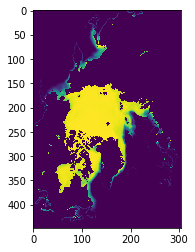



  8%|▊         | 1/12 [05:23<59:22, 323.83s/it]

(136192,)


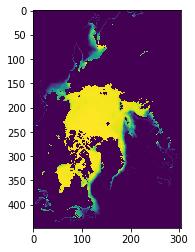



 17%|█▋        | 2/12 [10:41<53:39, 321.92s/it]

(136192,)


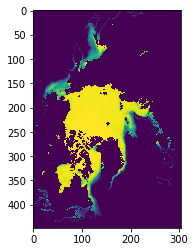



 25%|██▌       | 3/12 [15:59<48:06, 320.67s/it]

(136192,)


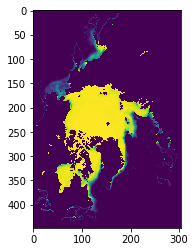



 33%|███▎      | 4/12 [21:23<42:53, 321.69s/it]

(136192,)


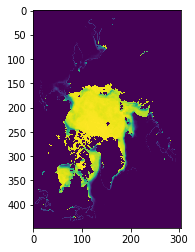



 42%|████▏     | 5/12 [27:01<38:05, 326.57s/it]

(136192,)


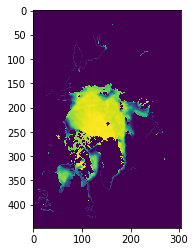



 50%|█████     | 6/12 [33:00<33:37, 336.32s/it]

(136192,)


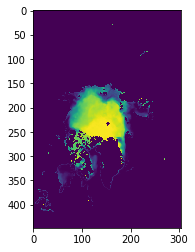



 58%|█████▊    | 7/12 [39:18<29:03, 348.80s/it]

(136192,)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  # x_train = datan[:10].reshape(10,-1).T
  # y_train = datan[10].reshape(1,-1).T
  # x_test = datan[1:11].reshape(10,-1).T

  # x_train = datan[:11].reshape(11,-1).T
  # y_train = datan[11].reshape(1,-1).T
  # x_test = datan[1:12].reshape(11,-1).T

  x_train = datan[7:18].reshape(11,-1).T
  y_train = datan[18].reshape(1,-1).T
  x_test = datan[8:19].reshape(11,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=430, weights='distance', p=1, n_jobs=-1)  #780
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

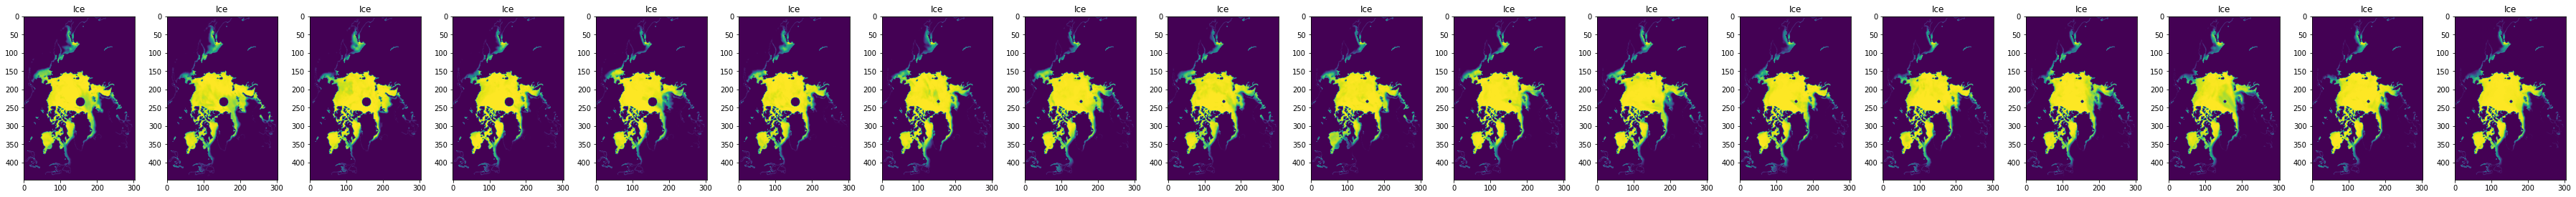

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, fun1(pred0).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

* Dacon 4.09의 결과물 : (n_neighbors=2000, weights='distance', algorithm='brute', p=1)
* Dacon 4.0859의 결과물 : (n_neighbors=1900, weights='distance', p=1, n_jobs=-1)
* Dacon 3.9763의 결과물: (n_neighbors=1000, weights='distance', p=1, n_jobs=-1)
* Dacon 3.9515의 결과물: (n_neighbors=780, weights='distance', p=1, n_jobs=-1)
* **Dacon 3.9020의 결과물: 11개의 데이터 (n_neighbors=400, weights='distance', p=1, n_jobs=-1)**
* Dacon 3.9239의 결과물: 16개의 데이터 (n_neighbors=350, weights='distance', p=1, n_jobs=-1)


## 데이터 4등분(4 Data)

#### 시험용

In [ ]:
# 데이터 1개
x_train = train0[:9].reshape(9,-1).T
y_train = train0[9].reshape(1,-1).T
x_test = train0[1:10].reshape(9,-1).T

real = train0[10]

In [ ]:
# 4등분 데이터 셋 생성
for i in range(4):
  print(i)

  globals()['x_train_{}'.format(i)] = train0[:9].reshape(9,-1)[:,34048*i:34048*(i+1)].T
  globals()['y_train_{}'.format(i)] = train0[9].reshape(1,-1)[:,34048*i:34048*(i+1)].T
  globals()['x_test_{}'.format(i)] = train0[1:10].reshape(9,-1)[:,34048*i:34048*(i+1)].T
  globals()['real_{}'.format(i)] = train0[10][112*i:112*(i+1),:304]

  print(globals()['x_train_{}'.format(i)].shape)
  print(globals()['y_train_{}'.format(i)].shape)
  print(globals()['x_test_{}'.format(i)].shape)
  print(globals()['real_{}'.format(i)].shape)

In [ ]:
# 실제 4등분 데이터 확인
import matplotlib.pyplot
matplotlib.pyplot.imshow(real_2, interpolation = 'None')
matplotlib.pyplot.title('자른 데이터 확인')

RandomForest 모델

In [ ]:
# RandomForest 모델 1
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_features='sqrt', n_estimators=600)
model.fit(x_train_2, y_train_2)

In [ ]:
# RandomForest 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# RandomForest 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# RandomForest 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

LARS Lasso 모델

In [ ]:
# LARS Lasso 모델 1
from sklearn import linear_model

model = linear_model.LassoLars(alpha=0.01)
model.fit(x_train_2, y_train_2)

In [ ]:
# LARS Lasso 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# LARS Lasso 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# LARS Lasso 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

DecisonTreeRegressor 모델

In [ ]:
# DecisionTreeRegressor 모델 1
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(criterion='mse')
model.fit(x_train_2, y_train_2)

In [ ]:
# DecisionTreeRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# DecisionTreeRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# DecisionTreeRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

HuberRegressor 모델

In [ ]:
# HuberRegressor 모델 1
from sklearn.linear_model import HuberRegressor

model = HuberRegressor()
model.fit(x_train_2, y_train_2)

In [ ]:
# HuberRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# HuberRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# HuberRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

SGDRegressor 모델

In [ ]:
# SGDRegressor 모델 1
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss='huber',learning_rate='optimal')
model.fit(x_train_2, y_train_2)

In [ ]:
# SGDRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# SGDRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# SGDRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

KNeighborsRegressor 모델

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=1300, weights='distance', algorithm='auto', p=1)  # 1500은 4.13, 2000은 4.17, 1300은 4.11, 1000은 4.13, 500은 4.16, 5000은 5.57
model.fit(x_train_2, y_train_2)

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train_2, y_train_2))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test_2)
pre = pre.reshape(-1)
pre 

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

항목의 발생 횟수를 계산
* https://www.delftstack.com/ko/howto/python/how-to-count-the-occurrences-of-an-item-in-a-one-dimensional-array-in-python/

In [ ]:
# 항목 확인
# 배열 내 중복된 원소 제거 후 유일한 원소를 정렬하여 반환
np.unique(np.abs(fun(pre)))

In [ ]:
# KNeighborsRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='auto', p=1)
  model.fit(x_train_2, y_train_2)

  pre = model.predict(x_test_2)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

#### KNeighborsRegressor4

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1)
  y_train = datan[10].reshape(1,-1)
  x_test = datan[1:11].reshape(10,-1)

  # 예측 데이터 생성
  predd = []

  # 4등분 데이터 셋 생성
  for j in range(4):
    a = globals()['x_train{}'.format(j)] = x_train[:,34048*j:34048*(j+1)].T
    b = globals()['y_train{}'.format(j)] = y_train[:,34048*j:34048*(j+1)].T
    c = globals()['x_test{}'.format(j)] = x_test[:,34048*j:34048*(j+1)].T

    # 모델 훈련
    model = KNeighborsRegressor(n_neighbors=1200, weights='distance', p=1, n_jobs=-1)
    model.fit(a, b)

    # 모델 예측
    predict = model.predict(c)
    
    predd.append(predict)

  # 완성된 예측 데이터 정제
  predictions = np.array(predd)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0.shape

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

#### KNeighborsRegressor3

In [ ]:
# 데이터셋 나누기 확인
x_train = train0[:10].reshape(10,-1)
x_train[:,:34048].T.shape, x_train[:,34048:102144].T.shape, x_train[:,102144:].T.shape

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1)
  y_train = datan[10].reshape(1,-1)
  x_test = datan[1:11].reshape(10,-1)

  # 예측 데이터 생성 (numpy)
  predd = np.array([])

  # 3등분 데이터 셋 생성
  x_train0, x_train1, x_train2 = x_train[:,:34048].T, x_train[:,34048:102144].T, x_train[:,102144:].T
  y_train0, y_train1, y_train2 = y_train[:,:34048].T, y_train[:,34048:102144].T, y_train[:,102144:].T
  x_test0, x_test1, x_test2 = x_test[:,:34048].T, x_test[:,34048:102144].T, x_test[:,102144:].T

  # 3등분의 모델
  for j in tqdm(range(3)):
    a = globals()['x_train{}'.format(j)]
    b = globals()['y_train{}'.format(j)]
    c = globals()['x_test{}'.format(j)]

    # 모델 훈련
    model = KNeighborsRegressor(n_neighbors=1900, weights='distance', p=1, n_jobs=-1)
    model.fit(a, b)

    # 모델 예측
    predict = model.predict(c)
    
    predd = np.append(predd, predict)

  # 완성된 예측 데이터 정제
  predictions = np.array(predd)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
predict.shape

In [ ]:
aaa = np.array([])

np.append(aaa, predict).shape

In [ ]:
predd

In [ ]:
predict.shape

In [ ]:
predictions.shape

In [ ]:
x_train0.shape

In [ ]:
a.shape, b.shape

In [ ]:
model = KNeighborsRegressor(n_neighbors=10, weights='distance', p=1, n_jobs=-1)
model.fit(a, b)

In [ ]:
# 모델 예측
predict = model.predict(c)

In [ ]:
predict.reshape(-1).shape

In [ ]:
np.array(predd).shape

In [ ]:
predictions.shape

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

# 제출

In [ ]:
# 제출 형태로 변환

# 데이터 생성
sh1 = pd.DataFrame(pred0.reshape(1,-1))  # 초기값 설정
sh1 = fun1(sh1)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred{}'.format(i+1)] = globals()['pred{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh1 = pd.concat((sh1, sh), axis=0)
  print(sh1.shape)

In [ ]:
# 1차 데이터 확인 (Pre-제출본)
sh1

In [ ]:
# sh1의 인덱스 수정

# 12개월, 24개월 투투
result = pd.concat([sh1,sh1], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'month'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [22]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/result/sub_0326_3_KNN.csv', index = False)